Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Adam Bakopolus"
COLLABORATORS = "1/24 Office Hours (LOWESS Algorithm and Block Bootstapping Sections), StackOverflow"

# Presenting Uncertainty
## School of Information, University of Michigan

## Week 4: Assignment Overview
Version 1.1
### The objectives for this week are for you to:
- recreate the visualization for tracking Donald Trump’s approval ratings throughout his presidency
- create an alternative uncertainty visualization of the same data using principles you learned in class
- analyze and compare the two visualizations

Read the FiveThirtyEight article [How popular/unpopular is Donald Trump](https://projects.fivethirtyeight.com/trump-approval-ratings/). 

The article is based on the datasets [approval_topline.csv](asset/approval_topline.csv) and [approval_poll_list.csv](asset/approval_poll_list.csv). Both of them are in the asset folder.

### Assignment Directions
For part 1 of this assignment, there are three required elements:
- Dots for individual approval/disapproval polls
- Uncertainty bands for the approval and disapproval data
- Line of best estimate (provided in the file)

Interactive elements are not required.

In [2]:
import pandas as pd
import altair as alt
import numpy as np

In [3]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Part 0. Load the data (2 points)

Load the "approval_topline.csv" file into the `topline_df` variable and the "approval_polllist.csv" file into the `polls_df` variable.

In [4]:
topline_df = pd.read_csv('asset/approval_topline.csv')
polls_df = pd.read_csv('asset/approval_poll_list.csv')
#raise NotImplementedError()

In [5]:
assert len(topline_df) == 3537, "Load the data: topline_df does not have the required number of rows"
assert len(topline_df.columns) == 10, "Load the data: topline_df does not have the required number of columns"
assert len(polls_df) == 11556, "Load the data: polls_df does not have the required number of rows"
assert len(polls_df.columns) == 22, "Load the data: polls_df does not have the required number of columns"

## Part 1. Recreate the first visualization for tracking Donald Trump’s approval ratings (10 points)

Note that the original visualization has a dropdown for selecting All Polls, Polls of likely or registered voters, or Polls of Adults. Pick just one of these subsets to visualize. (Hint: filter on the `subgroup` column in the dataset)

In [6]:
disapprove_line = alt.Chart(topline_df) \
                     .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                     .mark_line(color = 'orange') \
                     .encode(
                              x = alt.X('modeldate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('disapprove_estimate:Q', scale = alt.Scale (zero = False), title = None)
                            ) \
                     .properties(width = 700, height = 400, 
                                title={"text": ["How un/popular is Donald Trump?"], 
            "subtitle": ["An updating calculation of the president's approval rating, accounting for each poll's quality",
                        "recency, sample size and partisan lean. (Poll of Adults)"]})

approve_line =    alt.Chart(topline_df) \
                     .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                     .mark_line(color = 'green') \
                     .encode(
                              x = alt.X('modeldate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('approve_estimate:Q', scale = alt.Scale (zero = False), title = None)
                            ) \
                     .properties(width = 700, height = 400)

disapprove_points = alt.Chart(polls_df) \
                       .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                       .mark_point(color = 'orange', fill = 'orange', opacity = 0.08) \
                       .encode(
                              x = alt.X('enddate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('adjusted_disapprove:Q', scale = alt.Scale (zero = False), title = None)
                            ) \
                       .properties(width = 700, height = 400)

approve_points = alt.Chart(polls_df) \
                    .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                    .mark_point(color = 'green', fill = 'green', opacity = 0.08) \
                    .encode(
                              x = alt.X('enddate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('adjusted_approve:Q', scale = alt.Scale (zero = False), title = None)
                            ) \
                    .properties(width = 700, height = 400)

disapprove_area = alt.Chart(topline_df) \
                     .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                     .mark_area(color = 'orange', opacity = 0.2) \
                     .encode(
                              x = alt.X('modeldate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('disapprove_lo:Q', scale = alt.Scale (zero = False), title = None),
                              y2 = 'disapprove_hi:Q'
                            ) \
                     .properties(width = 700, height = 400)

approve_area = alt.Chart(topline_df) \
                     .transform_filter(
                               (alt.datum.subgroup == 'Adults')
                              ) \
                     .mark_area(color = 'green', opacity = 0.2) \
                     .encode(
                              x = alt.X('modeldate:T', axis = alt.Axis(format = "%b %Y"), title = None),
                              y = alt.Y('approve_lo:Q', scale = alt.Scale (zero = False), title = None),
                              y2 = 'approve_hi:Q'
                            ) \
                     .properties(width = 700, height = 400)

disapprove_line + approve_line + disapprove_points + approve_points + disapprove_area + approve_area

alt.LayerChart(...)

## Part 2. Use one of the techniques from class to create an alternative version of the visualization from Part 1 (15 points) 

Create an alternative uncertainty visualization to your visualization from Part 1. 

**NOTE:** You will either have to make some assumptions in order to construct an alternative visualization, or fit your own model to the data. Document your assumptions in Part 3.

In [7]:
#pip install tsmoothie

In [8]:
from tsmoothie.smoother import LowessSmoother
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [9]:
polls_adults = polls_df[polls_df['subgroup'] == 'Adults']

disapprove_x = polls_adults['enddate']
disapprove_y = polls_adults['adjusted_disapprove']

smoother_disapprove = LowessSmoother(smooth_fraction = .3, iterations = 1)
smoother_disapprove.smooth(disapprove_y)
lower_band_disapprove, upper_band_disapprove = smoother_disapprove.get_intervals('prediction_interval')

approve_x = polls_adults['enddate']
approve_y = polls_adults['adjusted_approve']

smoother_approve = LowessSmoother(smooth_fraction = .3, iterations = 1)
smoother_approve.smooth(approve_y)

lower_band_approve, upper_band_approve = smoother_approve.get_intervals('prediction_interval')

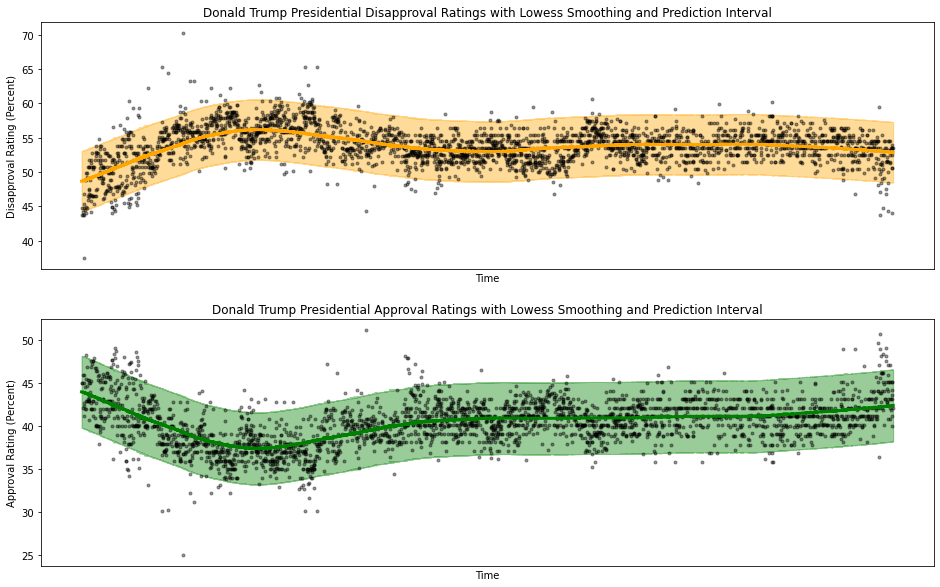

In [10]:
plt.figure(figsize = (16,10))

plt.subplot(2,1,1)

plt.plot(disapprove_x, smoother_disapprove.data[0], '.k', alpha = .4)
plt.plot(disapprove_x, smoother_disapprove.smooth_data[0], linewidth = 3, color = 'orange')
plt.fill_between(disapprove_x, lower_band_disapprove[0], upper_band_disapprove[0], color = 'orange', alpha = .4)

plt.title('Donald Trump Presidential Disapproval Ratings with Lowess Smoothing and Prediction Interval')
plt.xlabel('Time')
plt.ylabel('Disapproval Rating (Percent)')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.subplot(2,1,2)

plt.plot(approve_x, smoother_approve.data[0], '.k', alpha = .4)
plt.plot(approve_x, smoother_approve.smooth_data[0], linewidth = 3, color = 'green')
plt.fill_between(approve_x, lower_band_approve[0], upper_band_approve[0], color = 'green', alpha = .4)

plt.title('Donald Trump Presidential Approval Ratings with Lowess Smoothing and Prediction Interval')
plt.xlabel('Time')
plt.ylabel('Approval Rating (Percent)')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

## Part 3. Assumptions, Justification, and Comparison (5 points)

Document any assumptions you made in Part 2. Then, compare your visualization to the original, justifying your design choices.

In the Part 1 figure, Trump's calculated approval and disapproval ratings over time (2017-2020) are plotted as a line. All of the polls used to generate these calculated approval and disapproval rates were also plotted as points over time. Lastly, the plot had 90% confidence intervals plotted as an area for both the approval and disapproval rating trend lines.

For Part 2, there are now two subplots in a figure - one for disapproval ratings over time and the other for approval ratings. The polls available for this analysis are again plotted as points over time similar to Part 1. However, the different approach for this section was to utilize Lowess Smoothing to develop the approval and disapproval rating trend line based on the various available polls over time. As can be seen during a comparison, while Part 1 has sharp peaks and dips across time, the Lowess Smoothing approach creates a smooth line to fit the data and provides its own estimation for what the approval and disapproval rate may have been given the available data. However, the major difference between Part 1 and 2 is that while Part 1 utilized confidence intervals around its trending line, the Part 2 Lowess Smoothing approach I implemented utilizes prediction intervals. Prediction intervals are typically wider than confidence intervals as they are not assessing the confidence around the true trend line but are instead predicting a new point (poll) for a particular time period. I thought this was a new and interesting way of representing this analysis as an individual for a particular point in time would be given a prediction range where they'd be able to reasonably expect Trump's approval and disapproval rating to fall given new poll information being released.

Please remember to submit both the HTML and .ipynb formats of your completed notebook. When generating your HTML, be sure to run your complete code first before downloading as HTML. Please remember to work on your explanations and interpretations!